### 5.1.1 Using gpt to generate Text

In [43]:
%load_ext autoreload
%autoreload 2

from generate_text import generate_text

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [44]:
import torch
from gpt_model import GPTModel

In [45]:
GPT_CONFIG_124M = {
"vocab_size": 50257,
"context_length": 256,
"emb_dim": 768,
"n_heads": 12,
"n_layers": 12,
"drop_rate": 0.1,
"qkv_bias": False
}
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval()

GPTModel(
  (token_embeddings): Embedding(50257, 768)
  (position_embeddings): Embedding(256, 768)
  (drop_embeddings): Dropout(p=0.1, inplace=False)
  (transformer_blocks): Sequential(
    (0): TransformerBlock(
      (transformer): MultiHeadAttention(
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (feed_forward): FeedForwardNetwork(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNormalization()
      (norm2): LayerNormalization()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )


In [64]:

import tiktoken
def text_to_token(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special= {'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0)
    return encoded_tensor

def token_to_text(token_ids, tokenizer):
    flat = token_ids.flatten()
    return tokenizer.decode(flat.tolist())

start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")
token_ids = generate_text(
model=model,
idx=text_to_token(start_context, tokenizer),
max_tokens=10,
context_size=GPT_CONFIG_124M["context_length"]
)
print("Output text:\n", token_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you 960esame WindsorFE Keith awaitedSer GaelListMine


### 5.1.2 Calculating text generation loss


In [65]:
inputs = torch.tensor([[16833, 3626, 6100],[40, 1107, 588]])
#Every effort moves, I really like
#We want
#effort move you, really like chocolate
#Meaning for every token we want it to correctly predict the next token
targets = torch.tensor([[3626, 6100, 345 ], [1107, 588, 11311]])

In [66]:
with torch.no_grad():
    logits = model(inputs)
probas = torch.softmax(logits, dim=-1)
print(probas.shape)

torch.Size([2, 3, 50257])


In [67]:
#Next we find the arg max i.e for every token in each of the 2 examples we find the token with the highest probability
token_ids = torch.argmax(probas, dim=-1, keepdim=True)
print("Token ids:\n", token_ids)
print(f"Targets batch 1: {token_to_text(targets[0], tokenizer)}")
print(f"Outputs batch 1:"f" {token_to_text(token_ids[0].flatten(), tokenizer)}")

Token ids:
 tensor([[[13207],
         [  552],
         [42826]],

        [[18236],
         [34817],
         [ 7055]]])
Targets batch 1:  effort moves you
Outputs batch 1: hole compNetflix


We now want to evaluate this

In [68]:
text_idx = 0;
target_probas1 = probas[text_idx, [0,1,2], targets[text_idx]]
print("Target: 1\n",  target_probas1)
text_idx = 1;
target_probas2 = probas[text_idx, [0,1,2], targets[text_idx]]
print("Target: 2:\n", target_probas2)

Target: 1
 tensor([5.0549e-05, 2.7952e-05, 8.2801e-06])
Target: 2:
 tensor([1.2945e-05, 3.2755e-05, 5.2184e-06])


We want to maximize the above probs
We concatenate these 2 tensors into one and then apply log

In [69]:
log_probas = torch.log(torch.cat((target_probas1, target_probas2)))
print(log_probas)

tensor([ -9.8926, -10.4850, -11.7017, -11.2548, -10.3265, -12.1633])


In [70]:
avg_log_probas = torch.mean(log_probas)
print(avg_log_probas)

tensor(-10.9706)


In [71]:
neg_avg_log_probas = -1* avg_log_probas
print(neg_avg_log_probas)

tensor(10.9706)


In [72]:
print("Logits shape: ", logits.shape)
print("Target shape: ", targets.shape)

Logits shape:  torch.Size([2, 3, 50257])
Target shape:  torch.Size([2, 3])


For the cross_entropy loss function in PyTorch, we want to flatten these tensors
by combining them over the batch dimension:

In [73]:
logits_flat = logits.flatten(0,1 )
targets_flat = targets.flatten()
print("Flattened logits shape: ", logits_flat.shape)
print("Flattened targets shape: ", targets_flat.shape)

Flattened logits shape:  torch.Size([6, 50257])
Flattened targets shape:  torch.Size([6])


In [74]:
loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat)
print("Loss: ", loss)

Loss:  tensor(10.9706)


### 5.1.3 Training and validation losses

In [75]:
file_path="the-verdict.txt"
with open(file_path, 'r', encoding='utf-8') as file:
    text_data = file.read();
total_characters = len(text_data)
total_tokens =len(tokenizer.encode(text_data))
print("Characters: ", total_characters)
print("total_tokens: ", total_tokens)

Characters:  20398
total_tokens:  5064


In [76]:
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data= text_data[split_idx:]
print(len(train_data))
print(len(val_data))
print(len(train_data) + len(val_data))

18358
2040
20398


Next, we divide the dataset into a training and a validation set and use the data
loaders from text-processing.iypnb to prepare the batches for LLM training

In [77]:
from dataloader_v1 import create_dataloader_v1
torch.manual_seed(123)
train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)
val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)
print("Training loader:\n")
for x,y in train_loader:
    print(x.shape, y.shape)
print("validation loader: \n")
for x, y in val_loader:
    print(x.shape, y.shape)


Training loader:

torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
validation loader: 

torch.Size([2, 256]) torch.Size([2, 256])


Next, we implement a utility function to calculate the cross entropy loss of a given
batch returned via the training and validation loader:

In [78]:
def calc_loss_batch(input_batch, output_batch, device, model):
    input_batch = input_batch.to(device)
    output_batch = output_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0,1), output_batch.flatten())
    return loss 

In [79]:
def calc_loss_loader(data_loader, model ,device, num_batches=None):
    total_loss = 0
    if (len(data_loader) == 0):
        return float('nan')
    elif num_batches == None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, output_batch) in enumerate(data_loader):
        if (i < num_batches):
            loss = calc_loss_batch(input_batch, output_batch, device, model)
            total_loss += loss
        else:
            break
    return total_loss / num_batches

In [80]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)
print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: tensor(10.9995)
Validation loss: tensor(11.0198)


### 5.2 Training llm

In [88]:
def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs, eval_freq, eval_iter, start_context, tokenizer):
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = -1, 0
    for epoch in range(num_epochs):
        model.train()
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()
            loss = calc_loss_batch(input_batch, target_batch, device, model)
            loss.backward()
            optimizer.step()
            tokens_seen += input_batch.numel()#How many words it has processed
            global_step += 1
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")
        generate_and_print_sample(model, tokenizer, device, start_context)
    return train_losses, val_losses, track_tokens_seen


def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss


def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.position_embeddings.weight.shape[0]
    encoded = text_to_token(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text(model=model, idx=encoded,max_tokens=50, context_size=context_size)
    decoded_text = token_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))
    model.train()
        


                
    

In [89]:
torch.manual_seed(123)
model= GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(
model.parameters(),
lr=0.0004, weight_decay=0.1
)
num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(
model, train_loader, val_loader, optimizer, device,
num_epochs=num_epochs, eval_freq=5, eval_iter=5,
start_context="Every effort moves you", tokenizer=tokenizer)


Ep 1 (Step 000005): Train loss 8.420, Val loss 8.599
Every effort moves you,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Ep 2 (Step 000010): Train loss 7.097, Val loss 7.304
Ep 2 (Step 000015): Train loss 6.188, Val loss 6.663
Every effort moves you,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Ep 3 (Step 000020): Train loss 15.125, Val loss 15.469
Every effort moves you I had to the". "I, and I had. "I, and I had, and I had. " I had. "I, and I had. "I, and I had. ",
Ep 4 (Step 000025): Train loss 5.139, Val loss 6.393
Ep 4 (Step 000030): Train loss 4.820, Val loss 6.339
Every effort moves you in the Stroud on a little had been his his ". Gisburn, and I had been " I had the room, and it to me--his, and I had been "I, androud. "Oh,
Ep 5 (Step 000035): Train loss 4.072, Val loss 6.291
Ep 5 (Step 000040): Train loss 4.309, Val loss 6.161
Every effort moves you know his! I felt the of his pictures--as. "Oh, and I was his pictures--I I was his pictures--as, in the, I felt to have t

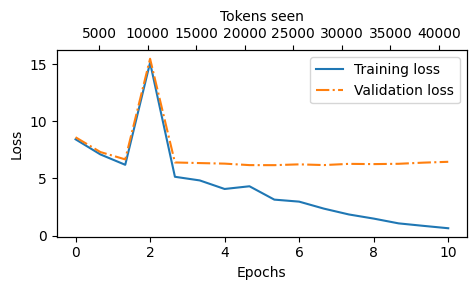

In [90]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax2 = ax1.twiny()
    ax2.plot(tokens_seen, train_losses, alpha=0)
    ax2.set_xlabel("Tokens seen")
    fig.tight_layout()
    plt.show()
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

The model is overfitting to the training data. We can confirm that the model memorizes the training data
verbatim by searching for the generated text snippets, such as quite insensible to
the irony in the “The Verdict” text file.  This memorization is expected since we are working with a very, very small training
dataset and training the model for multiple epochs. Usually, it’s common to train a
model on a much larger dataset for only one epoch